In [12]:
import ast

import h5py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pyvis.network import Network
from scipy import sparse

from sae_cooccurrence.utils.set_paths import get_git_root

In [13]:
git_root = get_git_root()

In [14]:
# load a thresholded matrix
# Load the thresholded matrix from npz file
thresholded_matrix = np.load(
    f"{git_root}/results/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/thresholded_matrices/thresholded_matrix_1_5.npz"
)["arr_0"]

node_df = pd.read_csv(
    f"{git_root}/results/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/dataframes/node_info_df_1_5.csv"
)

sparse_thresholded_matrix = sparse.load_npz(
    f"{git_root}/results/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/thresholded_matrices/sparse_thresholded_matrix_1_5.npz"
)

In [15]:
# make thresholded matrix upper triangular
thresholded_matrix = np.triu(thresholded_matrix)

In [16]:
subgraph_id = 125
# subgraph_nodes = node_df[node_df["subgraph_id"] == subgraph_id]["node_id"].tolist()
# # arrange nodes in ascending order
# subgraph_nodes = sorted(subgraph_nodes)

In [17]:
subgraph_df = node_df[node_df["subgraph_id"] == subgraph_id]
subgraph_df = subgraph_df[["node_id", "feature_activations"]]
subgraph_df.head()

,node_id,feature_activations
360,19054,928.0
361,5748,926.0
362,1179,777.0
363,125,655.0
364,734,750.0


In [18]:
subgraph_matrix = thresholded_matrix[subgraph_df["node_id"].tolist(), :][
    :, subgraph_df["node_id"].tolist()
]
subgraph = nx.from_numpy_array(subgraph_matrix)

# keep the node ids as the node names

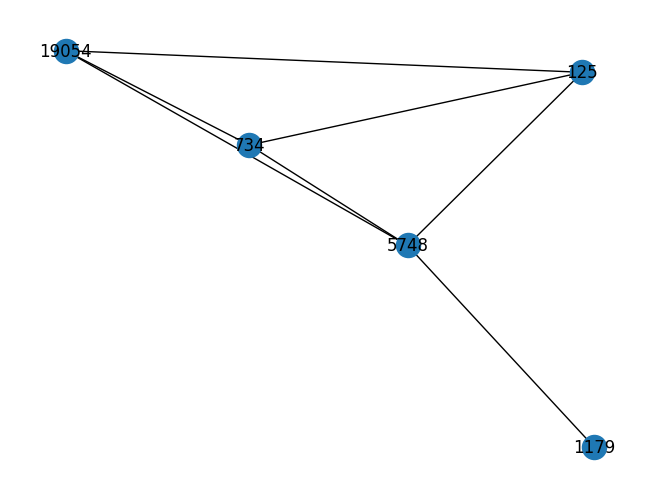

In [19]:
# Create a mapping of new indices to original node IDs
node_labels = {i: subgraph_df["node_id"].iloc[i] for i in range(len(subgraph_df))}

# plot the graph with the original node IDs as labels
nx.draw(subgraph, with_labels=True, labels=node_labels)
plt.show()

In [20]:
def generate_subgraph_plot_data(thresholded_matrix, node_df, subgraph_id):
    subgraph_df = node_df[node_df["subgraph_id"] == subgraph_id]
    subgraph_df = subgraph_df[["node_id", "feature_activations"]]
    subgraph_matrix = thresholded_matrix[subgraph_df["node_id"].tolist(), :][
        :, subgraph_df["node_id"].tolist()
    ]
    subgraph = nx.from_numpy_array(subgraph_matrix)
    return subgraph, subgraph_df

In [49]:
def generate_subgraph_plot_data_sparse(
    sparse_thresholded_matrix: sparse.csr_matrix,
    node_df: pd.DataFrame,
    subgraph_id: int,
):
    # Get nodes for this subgraph
    subgraph_df = node_df[node_df["subgraph_id"] == subgraph_id]
    subgraph_df = subgraph_df[["node_id", "feature_activations"]]
    node_indices = subgraph_df["node_id"].tolist()

    # Extract submatrix using sparse indexing
    subgraph_matrix = sparse_thresholded_matrix[node_indices, :][:, node_indices]  # type: ignore

    # Convert to networkx graph while keeping sparsity
    subgraph = nx.from_scipy_sparse_array(subgraph_matrix)

    return subgraph, subgraph_df

In [51]:
sparse_thresholded_matrix.shape

(24576, 24576)

In [46]:
subgraph, subgraph_df = generate_subgraph_plot_data_sparse(
    sparse_thresholded_matrix, node_df, subgraph_id
)

In [50]:
subgraph_df

,node_id,feature_activations
360,19054,928.0
361,5748,926.0
362,1179,777.0
363,125,655.0
364,734,750.0


In [23]:
subgraph, subgraph_df = generate_subgraph_plot_data(
    thresholded_matrix, node_df, subgraph_id
)

In [24]:
def plot_subgraph_static_v2(subgraph, subgraph_df):
    # Create a new figure
    plt.figure(figsize=(7, 7))

    # Create a layout for our nodes
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=1234)

    # Extract activations
    activations = subgraph_df["feature_activations"].values

    # Determine normalization range
    min_activation = min(activations)
    max_activation = max(activations)
    activation_range = max_activation - min_activation

    # Prepare node labels and colors
    labels = {}
    node_colors = []

    for i, node in enumerate(subgraph.nodes()):
        node_id = subgraph_df["node_id"].iloc[i]
        labels[node] = f"ID: {node_id}"

        # Normalize the node's activation
        if activation_range != 0:
            normalized_activation = (activations[i] - min_activation) / activation_range
        else:
            normalized_activation = 0.5

        node_colors.append(plt.cm.get_cmap("Blues")(normalized_activation))

    # Get edge weights
    edge_weights = [subgraph[u][v]["weight"] for u, v in subgraph.edges()]

    # Normalize edge weights for thickness
    if edge_weights:  # Only if there are edges
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        normalized_weights = [
            (w - min_weight) / (max_weight - min_weight) for w in edge_weights
        ]
        edge_thickness = [0.5 + 4.5 * w for w in normalized_weights]
    else:
        edge_thickness = []

    # Draw the graph
    nx.draw(
        subgraph,
        pos,
        with_labels=False,
        node_size=1000,
        node_color=node_colors,
        edgecolors="black",
        linewidths=3,
        edge_color=(0.5, 0.5, 0.5, 0.75),
        width=edge_thickness,
        arrows=True,
    )

    # Add node labels outside the nodes
    label_pos = {k: (v[0], v[1] - 0.12) for k, v in pos.items()}
    nx.draw_networkx_labels(subgraph, label_pos, labels, font_size=8)

    plt.axis("off")
    plt.tight_layout()
    plt.show()

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_68111/265798149.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


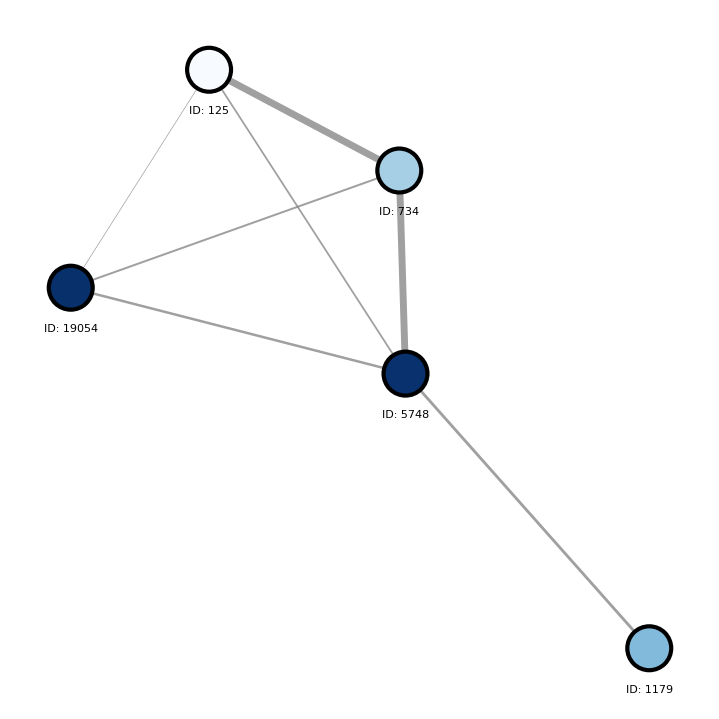

In [25]:
plot_subgraph_static_v2(subgraph, subgraph_df)

In [26]:
def load_dataset(dataset):
    if dataset.shape == ():  # Scalar dataset
        return dataset[()]
    else:  # Array dataset
        return dataset[:]


def decode_if_bytes(data):
    if isinstance(data, bytes):
        return data.decode("utf-8")
    elif isinstance(data, np.ndarray) and data.dtype.char == "S":
        return np.char.decode(data, "utf-8")
    return data

In [27]:
def load_subgraph_data(file_path, subgraph_id, load_options):
    with h5py.File(file_path, "r") as f:
        group = f[f"subgraph_{subgraph_id}"]
        results = {}

        # Conditionally load each component based on config
        if load_options["fired_tokens"]:
            results["all_fired_tokens"] = decode_if_bytes(
                load_dataset(group["all_fired_tokens"])  # type: ignore
            )

        if load_options["reconstructions"]:
            results["all_reconstructions"] = load_dataset(group["all_reconstructions"])  # type: ignore

        if load_options["graph_feature_acts"]:
            results["all_graph_feature_acts"] = load_dataset(
                group["all_graph_feature_acts"]  # type: ignore
            )  # type: ignore

        if load_options["feature_acts"]:
            results["all_feature_acts"] = load_dataset(group["all_feature_acts"])  # type: ignore

        if load_options["max_feature_info"]:
            results["all_max_feature_info"] = load_dataset(
                group["all_max_feature_info"]  # type: ignore
            )  # type: ignore

        if load_options["examples_found"]:
            results["all_examples_found"] = load_dataset(group["all_examples_found"])  # type: ignore

        if load_options["token_dfs"]:
            results["token_dfs"] = load_dataset(group["token_dfs"])  # type: ignore

        # Load pca_df
        pca_df_group = group["pca_df"]  # type: ignore
        pca_df_data = {}
        for column in pca_df_group.keys():  # type: ignore
            pca_df_data[column] = decode_if_bytes(
                load_dataset(pca_df_group[column])  # type: ignore
            )
        pca_df = pd.DataFrame(pca_df_data)

        return results, pca_df

In [28]:
example_h5 = load_subgraph_data(
    f"{git_root}/results/gpt2-small/res-jb-feature-splitting/blocks_8_hook_resid_pre_24576/blocks_8_hook_resid_pre_24576_pca_for_streamlit/graph_analysis_results_size_5_nbatch_100_v2.h5",
    125,
    {
        "fired_tokens": False,
        "reconstructions": False,
        "graph_feature_acts": True,
        "feature_acts": False,
        "max_feature_info": False,
        "examples_found": False,
        "token_dfs": False,
    },
)
example_h5

({'all_graph_feature_acts': array([[0.39923358, 0.        , 0.        , 0.        , 0.        ],
         [0.0361785 , 0.        , 0.        , 0.        , 0.        ],
         [0.39923358, 0.        , 0.        , 0.        , 0.        ],
         ...,
         [3.159606  , 0.        , 0.        , 0.        , 0.        ],
         [0.48917145, 0.        , 0.        , 0.        , 0.        ],
         [1.5471616 , 0.        , 0.        , 0.        , 0.        ]],
        dtype=float32)},
            PC1       PC2       PC3  \
 0    31.641127  1.323643 -2.184240   
 1    31.925072  1.350285 -2.188694   
 2    31.641130  1.323646 -2.184234   
 3    30.932337  0.145312 -1.699367   
 4    25.294121  2.689719 -0.090614   
 ..         ...       ...       ...   
 216  31.161131  1.278625 -2.176705   
 217  31.349392  1.580829 -1.890381   
 218  29.482298  1.121159 -2.150352   
 219  31.570789  1.317048 -2.183136   
 220  30.743357  1.239439 -2.170147   
 
                                      

In [29]:
def plot_subgraph_static_v3(
    subgraph,
    subgraph_df,
    node_info_df,
    output_path=None,
    activation_array=None,
    save_figs=False,
    normalize_globally=True,
) -> None:
    # Create a new figure
    plt.figure(figsize=(7, 7))

    # Create a layout for our nodes
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=1234)

    # Use provided activation_array if available, otherwise use subgraph_df
    if activation_array is None:
        activation_array = subgraph_df["feature_activations"].values

    # Extract activations for nodes in this subgraph
    subgraph_activations = [activation_array[i] for i in range(len(subgraph.nodes()))]

    # Determine normalization range
    if normalize_globally:
        min_activation = min(activation_array)
        max_activation = max(activation_array)
    else:
        min_activation = min(subgraph_activations)
        max_activation = max(subgraph_activations)

    activation_range = max_activation - min_activation

    # Prepare node labels and colors
    labels = {}
    node_colors = []

    for i, node in enumerate(subgraph.nodes()):
        node_id = subgraph_df["node_id"].iloc[i]

        # If node_info_df is provided, use top tokens, otherwise just use node_id
        if node_info_df is not None:
            node_info = node_info_df[node_info_df["node_id"] == node_id].iloc[0]
            top_tokens = ast.literal_eval(node_info["top_10_tokens"])
            top_token = top_tokens[0]
            labels[node] = f"ID: {node_id}\n{top_token}"
        else:
            labels[node] = f"ID: {node_id}"

        # Set fill to white if activation is 0, otherwise use the color map
        if subgraph_activations[i] == 0:
            node_colors.append("white")
        else:
            if activation_range != 0:
                normalized_activation = (
                    subgraph_activations[i] - min_activation
                ) / activation_range
            else:
                normalized_activation = 0.5
            node_colors.append(plt.cm.get_cmap("Blues")(normalized_activation))  # type: ignore

    # Get edge weights
    edge_weights = [subgraph[u][v]["weight"] for u, v in subgraph.edges()]

    # Normalize edge weights for thickness
    if edge_weights:  # Only if there are edges
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        normalized_weights = [
            (w - min_weight) / (max_weight - min_weight) for w in edge_weights
        ]
        edge_thickness = [0.5 + 4.5 * w for w in normalized_weights]
    else:
        edge_thickness = []

    # Draw the graph
    nx.draw(
        subgraph,
        pos,
        with_labels=False,
        node_size=1000,
        node_color=node_colors,
        edgecolors="black",
        linewidths=3,
        edge_color=(0.5, 0.5, 0.5, 0.75),
        width=edge_thickness,
        arrows=True,
    )

    # Add node labels outside the nodes
    label_pos = {k: (v[0], v[1] - 0.12) for k, v in pos.items()}
    nx.draw_networkx_labels(subgraph, label_pos, labels, font_size=8)

    plt.axis("off")
    plt.tight_layout()

    if save_figs:
        plt.savefig(f"{output_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{output_path}.pdf", format="pdf", dpi=300, bbox_inches="tight")
        plt.savefig(f"{output_path}.svg", format="svg", dpi=300, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_68111/1279891835.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


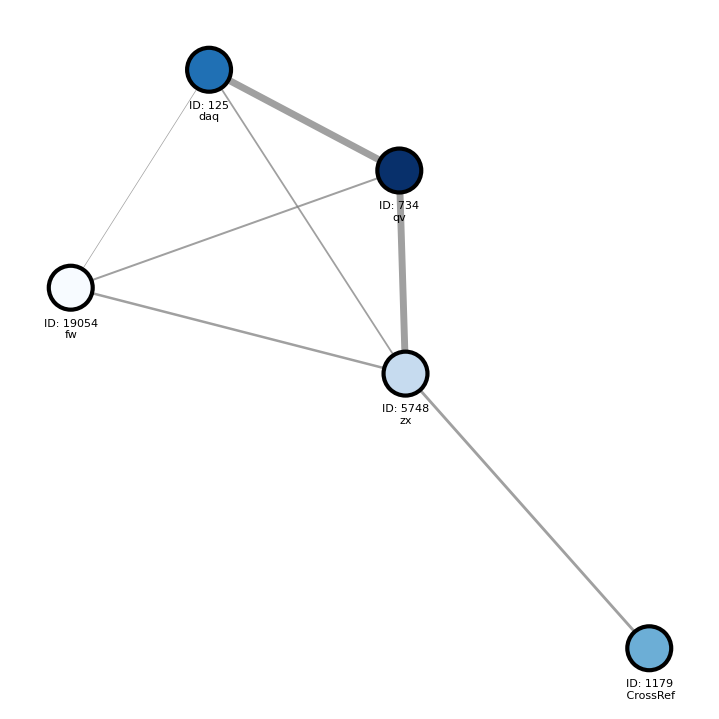

In [30]:
plot_subgraph_static_v3(
    subgraph, subgraph_df, node_df, activation_array=[0.1, 0.2, 0.3, 0.4, 0.5]
)

In [31]:
def plot_subgraph_static_v4(
    subgraph,
    subgraph_df,
    node_info_df,
    output_path=None,
    activation_array=None,
    save_figs=False,
    normalize_globally=True,
    base_node_size=1000,
    colour_when_inactive=True,
    plot_token_factors=False,
) -> None:
    # Create a new figure
    plt.figure(figsize=(7, 7))

    # Create a layout for our nodes
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=1234)

    # Use provided activation_array if available, otherwise use subgraph_df
    if activation_array is None:
        if colour_when_inactive:
            activation_array = subgraph_df["feature_activations"].values
        else:
            activation_array = [0] * len(subgraph.nodes())

    # Extract activations for nodes in this subgraph
    subgraph_activations = [activation_array[i] for i in range(len(subgraph.nodes()))]

    # Calculate node sizes based on feature activations
    feature_acts = subgraph_df["feature_activations"].values
    min_act = feature_acts.min()
    max_act = feature_acts.max()
    act_range = max_act - min_act
    if act_range != 0:
        normalized_sizes = (feature_acts - min_act) / act_range
        node_sizes = base_node_size + (normalized_sizes * base_node_size)
    else:
        node_sizes = [base_node_size] * len(feature_acts)

    # Determine normalization range for colors
    if normalize_globally:
        min_activation = min(activation_array)
        max_activation = max(activation_array)
    else:
        min_activation = min(subgraph_activations)
        max_activation = max(subgraph_activations)

    activation_range = max_activation - min_activation

    # Prepare node labels and colors
    labels = {}
    node_colors = []

    for i, node in enumerate(subgraph.nodes()):
        node_id = subgraph_df["node_id"].iloc[i]

        # If node_info_df is provided, use top tokens, otherwise just use node_id
        if node_info_df is not None:
            node_info = node_info_df[node_info_df["node_id"] == node_id].iloc[0]
            if plot_token_factors:
                top_tokens = ast.literal_eval(node_info["top_10_tokens"])
                top_token = top_tokens[0]
                labels[node] = f"ID: {node_id}\n{top_token}"
            else:
                labels[node] = f"ID: {node_id}"
        else:
            labels[node] = f"ID: {node_id}"

        # Set fill to white if activation is 0, otherwise use the color map
        if subgraph_activations[i] == 0:
            node_colors.append("white")
        else:
            if activation_range != 0:
                normalized_activation = (
                    subgraph_activations[i] - min_activation
                ) / activation_range
            else:
                normalized_activation = 0.5
            node_colors.append(plt.cm.get_cmap("Blues")(normalized_activation))

    # Get edge weights
    edge_weights = [subgraph[u][v]["weight"] for u, v in subgraph.edges()]

    # Normalize edge weights for thickness
    if edge_weights:  # Only if there are edges
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        normalized_weights = [
            (w - min_weight) / (max_weight - min_weight) for w in edge_weights
        ]
        edge_thickness = [0.5 + 4.5 * w for w in normalized_weights]
    else:
        edge_thickness = []

    # Draw the graph
    nx.draw(
        subgraph,
        pos,
        with_labels=False,
        node_size=node_sizes,  # Use calculated node sizes
        node_color=node_colors,
        edgecolors="black",
        linewidths=3,
        edge_color=(0.5, 0.5, 0.5, 0.75),
        width=edge_thickness,
        arrows=True,
    )

    # Add node labels outside the nodes
    # Adjust label positions based on node sizes
    label_pos = {k: (v[0], v[1] - 0.15) for k, v in pos.items()}
    nx.draw_networkx_labels(subgraph, label_pos, labels, font_size=8)

    plt.axis("off")
    plt.tight_layout()

    if save_figs:
        plt.savefig(f"{output_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{output_path}.pdf", format="pdf", dpi=300, bbox_inches="tight")
        plt.savefig(f"{output_path}.svg", format="svg", dpi=300, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_68111/2174524163.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


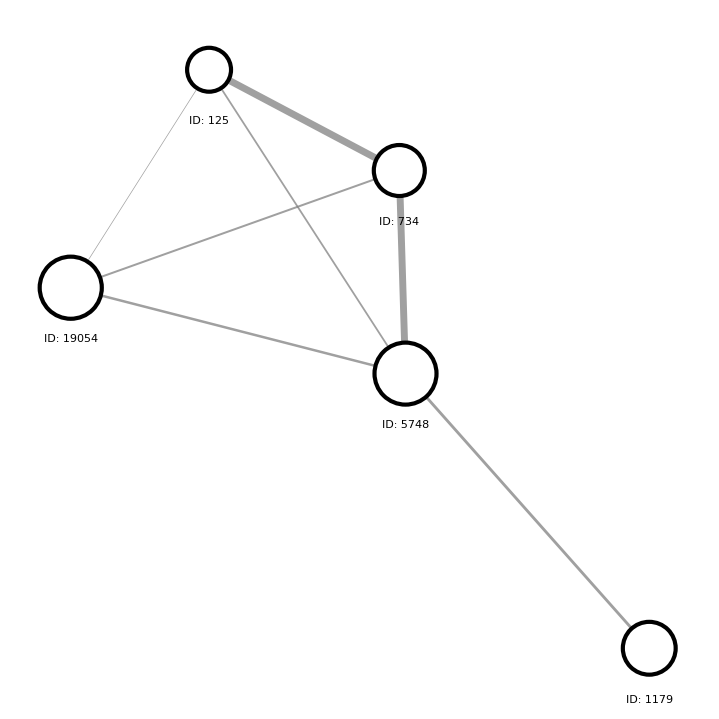

In [32]:
plot_subgraph_static_v4(subgraph, subgraph_df, node_df, colour_when_inactive=False)

In [33]:
# def plot_subgraph_interactive(
#     subgraph,
#     subgraph_df,
#     node_info_df,
#     activation_array=None,
#     colour_when_inactive=True,
#     plot_token_factors=False,
#     height="700px",
# ):
#     """Create an interactive network visualization using pyvis.
#     Returns HTML string for Streamlit components.html."""

#     # Initialize pyvis network
#     net = Network(
#         height=height,
#         width="100%",
#         bgcolor="#ffffff",
#         font_color=False,
#     )
#     net.toggle_physics(True)
#     net.barnes_hut(
#         gravity=-2000,
#         central_gravity=0.3,
#         spring_length=200,
#         spring_strength=0.05,
#         damping=0.09,
#         overlap=0,
#     )

#     # Use provided activation_array if available, otherwise use subgraph_df
#     if activation_array is None:
#         if colour_when_inactive:
#             activation_array = subgraph_df["feature_activations"].values
#         else:
#             activation_array = [0] * len(subgraph.nodes())

#     # Calculate node sizes based on feature activations
#     feature_acts = subgraph_df["feature_activations"].values
#     min_act = feature_acts.min()
#     max_act = feature_acts.max()
#     act_range = max_act - min_act
#     base_size = 30
#     if act_range != 0:
#         normalized_sizes = (feature_acts - min_act) / act_range
#         node_sizes = base_size + (normalized_sizes * base_size)
#     else:
#         node_sizes = [base_size] * len(feature_acts)

#     # Determine color normalization range
#     min_activation = min(activation_array)
#     max_activation = max(activation_array)
#     activation_range = max_activation - min_activation

#     # Add nodes
#     for i, node in enumerate(subgraph.nodes()):
#         node_id = subgraph_df["node_id"].iloc[i]

#         # Prepare node label
#         if node_info_df is not None:
#             node_info = node_info_df[node_info_df["node_id"] == node_id].iloc[0]
#             if plot_token_factors:
#                 top_tokens = ast.literal_eval(node_info["top_10_tokens"])
#                 top_token = top_tokens[0]
#                 label = f"ID: {node_id}\n{top_token}"
#             else:
#                 label = f"ID: {node_id}"
#         else:
#             label = f"ID: {node_id}"

#         # Calculate node color
#         if activation_array[i] == 0:
#             color = "#ffffff"  # white
#         else:
#             if activation_range != 0:
#                 normalized_activation = (
#                     activation_array[i] - min_activation
#                 ) / activation_range
#                 # Convert to hex color from blues colormap
#                 rgba = plt.cm.get_cmap("Blues")(normalized_activation)
#                 color = f"#{int(rgba[0]*255):02x}{int(rgba[1]*255):02x}{int(rgba[2]*255):02x}"
#             else:
#                 color = "#084594"  # Default blue

#         # Add node to network
#         # net.add_node(
#         #     node,
#         #     label=label,
#         #     color={"background": color, "border": "#000000"},
#         #     size=node_sizes[i],
#         #     borderWidth=2,
#         #     title=f"Activation: {subgraph_df['feature_activations'].iloc[i]:.2f}",
#         # )

#         net.add_node(
#             node,
#             label=label,
#             color=color,  # Changed from dict to string
#             size=node_sizes[i],
#             borderWidth=2,
#             title=f"Activation: {subgraph_df['feature_activations'].iloc[i]:.2f}",
#         )

#     # Add edges
#     for u, v in subgraph.edges():
#         weight = subgraph[u][v]["weight"]
#         # Scale width between 1 and 5 based on weight
#         width = (
#             1
#             + 4 * (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))
#             if edge_weights
#             else 1
#         )
#         net.add_edge(u, v, width=width, color={"color": "rgba(128, 128, 128, 0.75)"})

#     # Generate HTML
#     html = net.generate_html(notebook=False)
#     return net, html

In [34]:
# net, html = plot_subgraph_interactive(
#     subgraph, subgraph_df, node_df, colour_when_inactive=False
# )

NameError: name 'edge_weights' is not defined

In [96]:
# net.show("network.html")

network.html


AttributeError: 'NoneType' object has no attribute 'render'

In [109]:
def plot_subgraph_interactive(
    subgraph,
    subgraph_df,
    node_info_df,
    activation_array=None,
    colour_when_inactive=True,
    plot_token_factors=False,
    height="700px",
    width="700px",
):
    # Initialize pyvis network with notebook=True
    net = Network(
        height=height,
        width="100%",
        bgcolor="#ffffff",
        font_color=False,
        notebook=True,  # Add this parameter
    )

    # Get edge weights for scaling
    edge_weights = [subgraph[u][v]["weight"] for u, v in subgraph.edges()]

    # Rest of your existing configuration
    net.toggle_physics(True)
    net.barnes_hut(
        gravity=-2000,
        central_gravity=0.3,
        spring_length=200,
        spring_strength=0.05,
        damping=0.09,
        overlap=0,
    )

    # Use provided activation_array if available
    if activation_array is None:
        if colour_when_inactive:
            activation_array = subgraph_df["feature_activations"].values
        else:
            activation_array = [0] * len(subgraph.nodes())

    # Calculate node sizes
    feature_acts = subgraph_df["feature_activations"].values
    min_act = feature_acts.min()
    max_act = feature_acts.max()
    act_range = max_act - min_act
    base_size = 10

    if act_range != 0:
        normalized_sizes = (feature_acts - min_act) / act_range
        node_sizes = base_size + (normalized_sizes * base_size)
    else:
        node_sizes = [base_size] * len(feature_acts)

    # Color normalization
    min_activation = min(activation_array)
    max_activation = max(activation_array)
    activation_range = max_activation - min_activation

    # Add nodes
    for i, node in enumerate(subgraph.nodes()):
        node_id = subgraph_df["node_id"].iloc[i]

        # Prepare label
        if node_info_df is not None:
            node_info = node_info_df[node_info_df["node_id"] == node_id].iloc[0]
            if plot_token_factors:
                top_tokens = ast.literal_eval(node_info["top_10_tokens"])
                label = f"ID: {node_id}\n{top_tokens[0]}"
            else:
                label = f"ID: {node_id}"
        else:
            label = f"ID: {node_id}"

        # Calculate color
        if activation_array[i] == 0:
            color = "#ffffff"
        else:
            if activation_range != 0:
                normalized_activation = (
                    activation_array[i] - min_activation
                ) / activation_range
                rgba = plt.cm.get_cmap("Blues")(normalized_activation)
                color = f"#{int(rgba[0]*255):02x}{int(rgba[1]*255):02x}{int(rgba[2]*255):02x}"
            else:
                color = "#084594"

        # Add node
        net.add_node(
            node,
            label=label,
            color=color,  # Changed from dict to string
            size=node_sizes[i],
            borderWidth=2,
            title=f"Activation: {subgraph_df['feature_activations'].iloc[i]:.2f}",
        )

    # Add edges
    for u, v in subgraph.edges():
        weight = subgraph[u][v]["weight"]
        width = 1
        if edge_weights:
            width = 1 + 4 * (weight - min(edge_weights)) / (
                max(edge_weights) - min(edge_weights)
            )
        net.add_edge(u, v, width=width, color={"color": "rgba(128, 128, 128, 0.75)"})

    html = net.generate_html(notebook=False)
    return net, html


# Usage:
net, html = plot_subgraph_interactive(
    subgraph, subgraph_df, node_df, colour_when_inactive=False
)

# save html to file
with open("subgraph.html", "w") as f:
    f.write(html)

In [110]:
def plot_subgraph_static_from_nx(
    subgraph: nx.Graph,
    subgraph_df: pd.DataFrame,
    node_info_df: pd.DataFrame | None = None,
    output_path: str | None = None,
    activation_array: np.ndarray | None = None,
    save_figs: bool = False,
    normalize_globally: bool = True,
    base_node_size: int = 1000,
    colour_when_inactive: bool = True,
    plot_token_factors: bool = False,
) -> None:
    # Create a new figure
    plt.figure(figsize=(7, 7))

    # Create a layout for our nodes
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=1234)

    # Use provided activation_array if available, otherwise use subgraph_df
    if activation_array is None:
        if colour_when_inactive:
            activation_array = np.array(subgraph_df["feature_activations"].values)
        else:
            activation_array = np.zeros(len(subgraph.nodes()))

    # Extract activations for nodes in this subgraph
    subgraph_activations = [activation_array[i] for i in range(len(subgraph.nodes()))]

    # Calculate node sizes based on feature activations
    feature_acts = np.array(subgraph_df["feature_activations"].values)
    min_act = feature_acts.min()
    max_act = feature_acts.max()
    act_range = max_act - min_act
    if act_range != 0:
        normalized_sizes = (feature_acts - min_act) / act_range
        node_sizes = base_node_size + (normalized_sizes * base_node_size)
    else:
        node_sizes = [base_node_size] * len(feature_acts)

    # Determine normalization range for colors
    if normalize_globally:
        min_activation = min(activation_array)
        max_activation = max(activation_array)
    else:
        min_activation = min(subgraph_activations)
        max_activation = max(subgraph_activations)

    activation_range = max_activation - min_activation

    # Prepare node labels and colors
    labels = {}
    node_colors = []

    for i, node in enumerate(subgraph.nodes()):
        node_id = subgraph_df["node_id"].iloc[i]

        # If node_info_df is provided, use top tokens, otherwise just use node_id
        if node_info_df is not None:
            node_info = node_info_df[node_info_df["node_id"] == node_id].iloc[0]
            if plot_token_factors:
                top_tokens = ast.literal_eval(node_info["top_10_tokens"])
                top_token = top_tokens[0]
                labels[node] = f"ID: {node_id}\n{top_token}"
            else:
                labels[node] = f"ID: {node_id}"
        else:
            labels[node] = f"ID: {node_id}"

        # Set fill to white if activation is 0, otherwise use the color map
        if subgraph_activations[i] == 0:
            node_colors.append("white")
        else:
            if activation_range != 0:
                normalized_activation = (
                    subgraph_activations[i] - min_activation
                ) / activation_range
            else:
                normalized_activation = 0.5
            node_colors.append(plt.cm.get_cmap("Blues")(normalized_activation))

    # Get edge weights
    edge_weights = [subgraph[u][v]["weight"] for u, v in subgraph.edges()]

    # Normalize edge weights for thickness
    if edge_weights:  # Only if there are edges
        max_weight = max(edge_weights)
        min_weight = min(edge_weights)
        normalized_weights = [
            (w - min_weight) / (max_weight - min_weight) for w in edge_weights
        ]
        edge_thickness = [0.5 + 4.5 * w for w in normalized_weights]
    else:
        edge_thickness = []

    # Draw the graph
    nx.draw(
        subgraph,
        pos,
        with_labels=False,
        node_size=node_sizes,  # Use calculated node sizes
        node_color=node_colors,
        edgecolors="black",
        linewidths=3,
        edge_color=(0.5, 0.5, 0.5, 0.75),
        width=edge_thickness,
        arrows=True,
    )

    # Add node labels outside the nodes
    # Adjust label positions based on node sizes
    label_pos = {k: (v[0], v[1] - 0.15) for k, v in pos.items()}
    nx.draw_networkx_labels(subgraph, label_pos, labels, font_size=8)

    plt.axis("off")
    plt.tight_layout()

    if save_figs:
        plt.savefig(f"{output_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{output_path}.pdf", format="pdf", dpi=300, bbox_inches="tight")
        plt.savefig(f"{output_path}.svg", format="svg", dpi=300, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_42946/266097783.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  node_colors.append(plt.cm.get_cmap("Blues")(normalized_activation))
/var/folders/gj/gtktc0xd6vd23yfx6f6gp_lm0000gn/T/ipykernel_42946/266097783.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


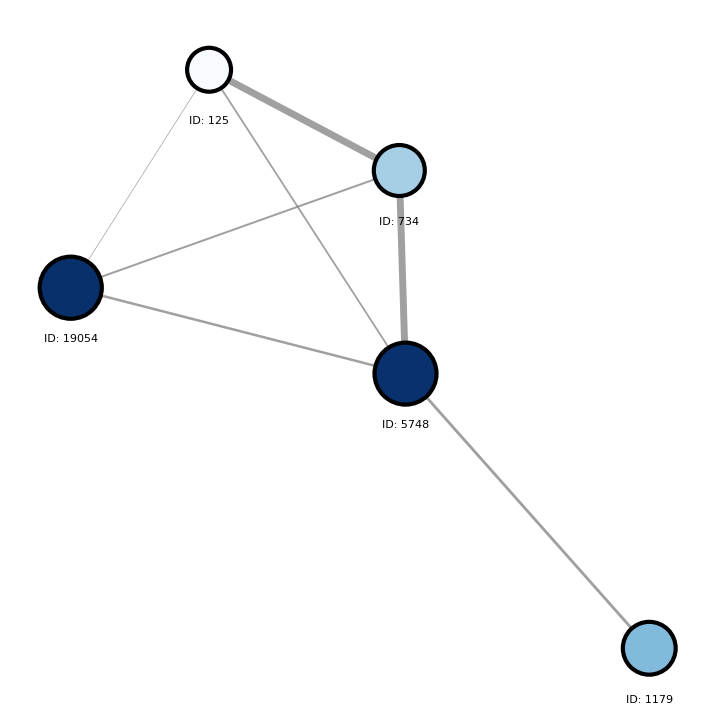

In [111]:
plot_subgraph_static_from_nx(subgraph, subgraph_df, node_df, output_path="subgraph")